In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.3.0
[]



### BERT에 사용되는 [MASK], [SEP], [CLS] 등의 주요 특수문자가 vocab에 포함

In [ ]:
import sentencepiece as spm
import os
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
prefix = 'ko_32000'
vocab_size = 32000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

print("완료=3")   # 완료메시지가 출력될 때까지 아무 출력내용이 없더라도 기다려 주세요.

In [ ]:
corpus_file[:4]

### 토크나이저 생성

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

### 토크나이저 확인

In [ ]:
# 특수 token 7개를 제외한 나머지 tokens 들
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))
print(vocab_list)

* SentencePiece 모델을 이용해 간단한 BERT의 Masked Language Model 학습용 데이터를 하나 생성

In [ ]:
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

* BERT의 Masked Language Model은 GPT의 Next Token Prediction 태스크처럼 [다음이 이어질 단어는?] 을 맞추는 게 아니라 마스킹된 [다음 빈칸에 알맞은 단어는?] 문제를 푸는 형식으로 구성됩니다. 이런 빈칸은 전체 토큰의 15% 정도가 적당

In [ ]:
print(tokens_org)
print(len(tokens_org))
print(tokens_org[0])
# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt

* 15%를 마스킹한다고 해도 생각해 볼 것이 더 있습니다. Subword 기반으로 토크나이징을 했을 때 _대, [MASK], 민국이라고 가운데를 마스킹했을 경우 해당 [MASK]가 '한'일 거라는 건 너무 쉽게 맞출 수 있습니다. '대한민국'이라는 패턴을 아주 자주 보게 될 테니까요.

* 그래서 Masked LM 태스크를 구성할 땐 띄어쓰기 단위로 한꺼번에 마스킹해 주는 것이 좋습니다. 다음과 같이 처리합니다.

In [ ]:
print(u"\u2581")

In [ ]:
# 띄어쓰기 단위로 mask 하기 위해서 index 분할
cand_idx = []  # word 단위의 index array

for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue# 종료시점
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):# 첫 숫자 입력 후 쭉, 밑줄시작 아니면
        cand_idx[-1].append(i)# [] 안에 추가
    else:
        cand_idx.append([i])# 새로운 시작점

# 결과확인
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

In [ ]:
# random mask를 위해서 순서를 섞음
random.shuffle(cand_idx)
cand_idx

* 개선된 Masking 로직을 다음과 같이 구현해 보았습니다. 마스킹 된 결과를 이전과 비교해 보시죠.

In [ ]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

mask_lms = []  # mask 된 값
for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
          break
    if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
          continue
    dice = random.random()  # 0..1 사이의 확률 값

    for index in index_set:
        masked_token = None
        if dice < 0.8:  # 80% replace with [MASK]
            masked_token = "[MASK]"
        elif dice < 0.9: # 10% keep original
            masked_token = tokens[index]
        else:  # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

* Masked LM의 라벨 데이터도 아래와 같이 생성하여 정리해 둡니다.

In [ ]:
# 순서 정렬 및 mask_idx, mask_label 생성
mask_lms = sorted(mask_lms, key=lambda x: x["index"])
mask_idx = [p["index"] for p in mask_lms]
mask_label = [p["label"] for p in mask_lms]

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

* 🔶 create_pretrain_mask() : Masked LM을 위한 코퍼스 생성 메소드
이번 스텝에서 구현할 최종 메소드는 아래와 같습니다.

In [ ]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

* create_pretrain_mask() 수행 결과를 다시 한번 확인해 봅시다.

In [ ]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

### 16-4. 데이터 전처리 (2) NSP pair 생성
* BERT의 pretrain task로 Next Sentence Prediction이 있습니다. 문장 2개를 붙여 놓고 두 문장이 이어지는 것인지 아닌지 문장 호응관계를 맞출 수 있게 하는 것입니다. 아래 문장을 예시로 진행해 보겠습니다.

In [ ]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [ ]:
# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

In [ ]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [ ]:
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        #######################################
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
          
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

* 짝지은 두 문장을 그대로 두면 NSP task의 true label 케이스가 되고, 둘의 순서를 뒤바꾸면 false label 케이스가 되겠죠? 두 문장의 최대 길이를 유지하도록 trim을 적용한 후 50%의 확률로 true/false 케이스를 생성해 보겠습니다.

In [ ]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [ ]:
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        #######################################
        if random.random() < 0.5:  # 50% 확률로 swap
            is_next = 0
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

* 이제 두 문장 사이에 segment 처리를 해주어야 합니다. 첫 번째 문장의 segment는 모두 0으로, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주는 것으로 마무리됩니다.


* 이전 스텝의 create_pretrain_mask()까지 함께 호출되어 Mask LM용 데이터셋과 NSP용 데이터셋이 결합된 하나의 데이터셋으로 완성될 것입니다. BERT의 pretrain 은 두가지 task가 동시에 수행되니까요.

In [ ]:
instances = []
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        if random.random() < 0.5:  # 50% 확률로 swap
            is_next = 0
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        # tokens & aegment 생성
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
        segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        print("tokens:", len(tokens), tokens)
        print("segment:", len(segment), segment)
        # mask
        tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
        print("masked tokens:", len(tokens), tokens)
        print("masked index:", len(mask_idx), mask_idx)
        print("masked label:", len(mask_label), mask_label)

        instance = {
            "tokens": tokens,
            "segment": segment,
            "is_next": is_next,
            "mask_idx": mask_idx,
            "mask_label": mask_label
        }
        instances.append(instance)
        #######################################
        print()

        current_chunk = []
        current_length = 0

In [ ]:
# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

* 🔶 create_pretrain_instances() : Next Sentence Prediction을 위한 코퍼스 생성 메소드

* 이번 스텝에서 구현할 최종 메소드는 아래와 같습니다.

In [ ]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

* create_pretrain_instances() 수행 결과를 다시 한번 확인해 봅시다.

In [ ]:
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

## 16-5. 데이터 전처리 (3) 데이터셋 완성

* 이제 우리가 다루어야 할 kowiki.txt에 대해 본격적으로 들여다보겠습니다.

In [ ]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

* 전체 라인 수가 확인되시나요? 거의 400만 개에 육박하는 수치입니다.

* 위키 문서는 하나의 도큐먼트가 주제 키워드에 대해 상세 내용이 설명으로 따라붙어 있는 형태로 구성되어 있지요? 도큐먼트 주제별로 잘 나눠지는지도 확인해 보겠습니다.

In [ ]:
# 위키가 주제별로 잘 나눠지는지 여부 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:  # doc에 저장
            pieces = vocab.encode_as_pieces(line)
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

* 이전 스텝에서 완성했던 create_pretrain_instances()를 코퍼스에 적용할 수 있는지 몇 라인에 대해서만 확인해 봅시다.

In [ ]:
# instance 생성 기능 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # 테스트를 위해서 부분 처리 함
                    count -= 1
                else:
                    break
        else:  # doc에 저장
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

* 🔶 make_pretrain_data() : BERT pretrain 데이터셋 생성 메소드
* 전체 전처리 과정을 거쳐 최종적으로 만들어지는 BERT pretrain 데이터셋 생성 메소드는 다음과 같습니다.

In [ ]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

* 이제 약 400만 라인에 해당하는 전체 코퍼스에 대해 make_pretrain_data()를 구동해 봅시다. 10여 분가량 시간이 소요될 수 있습니다.
* 최종적으로 생성된 데이터셋은 json 포맷으로 저장될 것입니다.

In [ ]:
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

In [ ]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

* 데이터셋 파일을 만드는 것까지 수행되었습니다.

* 하지만 여기서 고려해야 할 점이 있습니다. 우리가 다루어야 할 데이터셋은 사이즈가 큽니다. 만들어질 json 데이터파일의 크기가 1.4GB 정도 됩니다. 실제 BERT 학습용dml 백 분의 일 사이즈 정도밖에 안 되겠지만 그럼에도 불구하고 이렇게 큰 파일을 로딩하는 함수를 만들 때는 메모리 사용량과 관련해 고려해야 할 점이 있습니다.

* 그래서 우리는 np.memmap을 사용해서 메모리 사용량을 최소화하는 방법을 시도해 볼 것입니다.

In [ ]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

만들어진 json 파일을 라인 단위로 읽어 들여 np.memmap에 로딩해 봅시다.

In [ ]:
# 라인 단위로 처리
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 5 < i:  # 테스트를 위해서 5개만 확인
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=np.int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
        label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

## 🔶 load_pre_train_data() : 학습에 필요한 데이터를 로딩하는 함수
* np.memmap을 사용해 메모리 효율적으로 만들어진 데이터를 로딩하는 함수를 아래와 같이 구성하였습니다.

In [ ]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [ ]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

In [ ]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

## 16-6. BERT 모델 구현


* 이제 본격적으로 BERT model을 구현해 보겠습니다.

* BERT가 transformer encoder로 구현되어 있다는 것은 잘 알고 계시리라 생각합니다. 이미 여러 번 다뤄보셨을 transformer의 모델구조와 거의 유사하지만, 아래 그림과 같이 3개의 embedding 레이어를 가진다는 점에 유의해야 합니다.

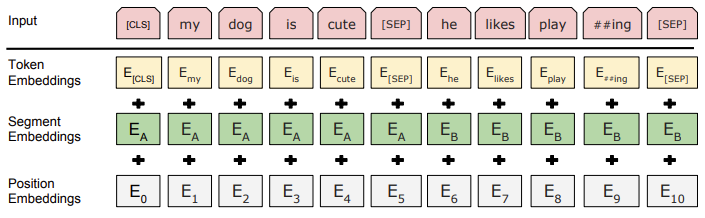

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask
print("슝=3")

In [ ]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))
print("슝=3")

In [ ]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer
print("슝=3")

In [ ]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
print("슝=3")

이제 본격적으로 embedding 레이어를 쌓아나가겠습니다. 아래는 Token Embedding의 구현입니다.

In [ ]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs
print("슝=3")

Positional Embedding 레이어는 다음과 같습니다.

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed
print("슝=3")

상대적으로 매우 간단한 Segment Embedding은 별도의 레이어를 구현하지 않고 BERT 클래스에서 간단히 포함하도록 하겠습니다.

아래는 자주 보았던 ScaleDotProductAttention과 이를 활용한 MultiHeadAttention입니다.

In [ ]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out
print("슝=3")

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out
print("슝=3")

이를 바탕으로 transformer encoder 레이어를 구성하겠습니다.

In [ ]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val
print("슝=3")

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
print("슝=3")

이제 다 왔습니다.

최종적으로 구성할 BERT 레이어는 아래와 같습니다.

In [ ]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed
print("슝=3")

BERT 레이어를 바탕으로 최종적으로 만들어질 pretrain용 BERT 모델 구성은 아래와 같습니다.

In [ ]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs
print("슝=3")

In [ ]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model
print("슝=3")

아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 확인해 보겠습니다.

In [ ]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

In [ ]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

test_model.fit()이 잘 구동되나요?

다음 스텝에서 본격적으로 학습을 진행해 보겠습니다.

## 16-7. pretrain 진행

loss나 accuracy같이 기본적으로 필요한 계산 함수를 미리 정의해 둡시다.

In [ ]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴
print("슝=3")

In [ ]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy
print("슝=3")

Learning Rate 스케줄링도 아래와 같이 구현합니다. WarmUp 이후 consine 형태로 감소하는 스케줄을 적용합니다.



In [ ]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
print("슝=3")

In [ ]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [ ]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

이제 본격적으로 학습을 진행합니다. 1Epoch만 학습하는 데도 10분 이상의 상당한 시간이 소요될 것입니다. 그리고 메모리 오류가 날 수 있으니 배치 사이즈에도 유의해 주세요. 참고로 우리는 전체 데이터셋 중의 1/7 수준인 128000건만 로딩해서 사용 중이라는 것을 기억합시다.

In [ ]:
epochs = 3
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

In [ ]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

In [ ]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()